# Measure GRACE performance on identified objects from the **ANNOTATED MASK**:

In [21]:
import numpy as np
import numpy.typing as npt

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib.colors import to_rgb
from scipy.ndimage import label


In [74]:
from grace.base import GraphAttrs
from grace.io.image_dataset import ImageGraphDataset

from grace.evaluation.process import (
    generate_ground_truth_graph,
    assume_dummy_predictions_from_annotations,
)

from grace.evaluation.visualisation import display_image_and_grace_annotation
from grace.evaluation.metrics import plot_iou_histogram

### Create an image annotation automatically:

In [3]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(image_dir=grace_path, grace_dir=grace_path)
image, graph_data = dataset[0]
hand_anno = graph_data["annotation"]
G = graph_data["graph"]


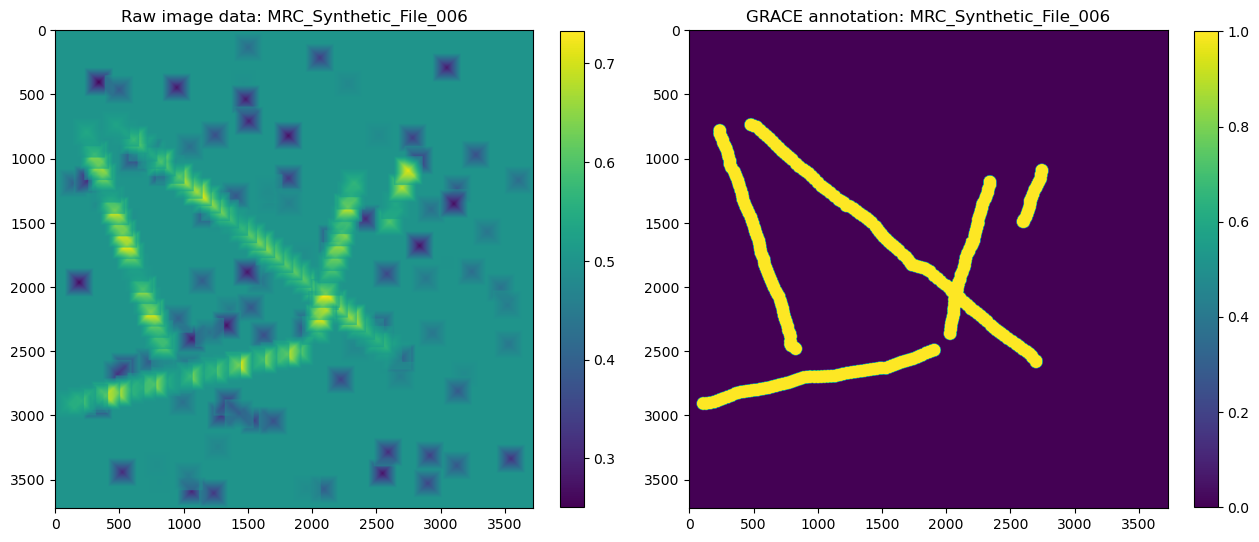

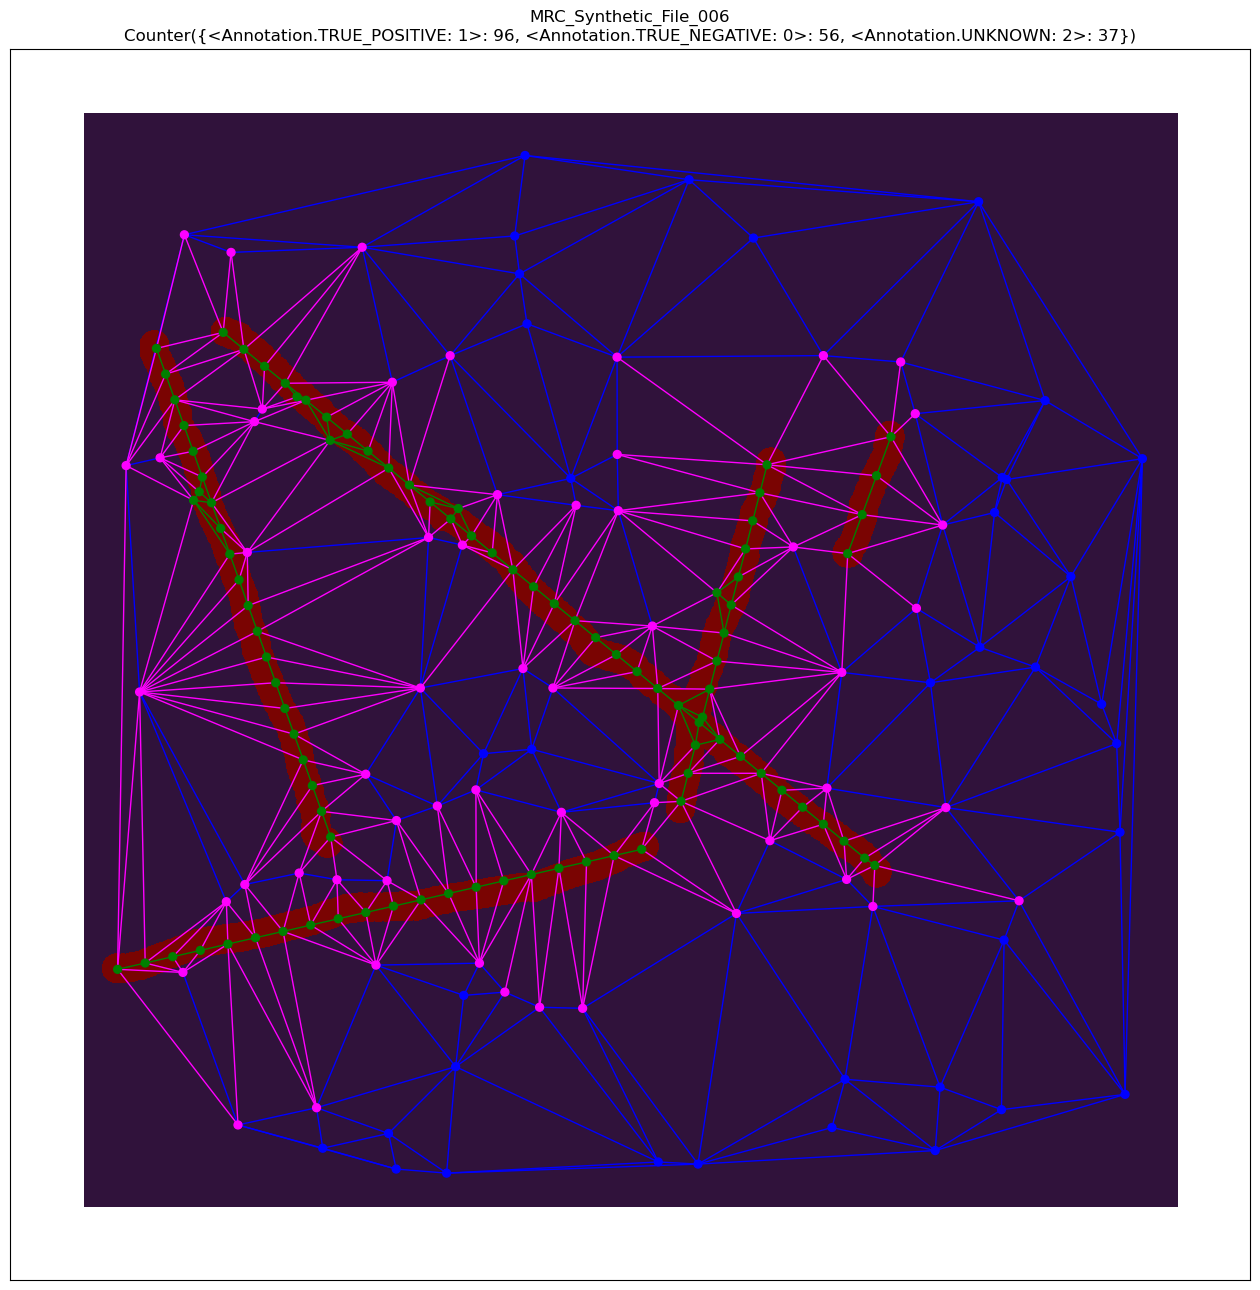

In [4]:
assume_dummy_predictions_from_annotations(G)
gt_graph = generate_ground_truth_graph(G)
display_image_and_grace_annotation(image=image, target=graph_data)

### Draw annotation with certain brush size:

In [5]:
def draw_annotation_mask_from_ground_truth_graph(gt_graph: nx.Graph, shape: tuple[int, int], brush_size: int = 75) -> npt.NDArray:
    """Create a binary annotation mask from ground truth graph, 
    which may contain all nodes but only contains real edges.
    
    Parameters
    ----------
    gt_graph : nx.Graph
        The ground truth graph.
    shape : tuple[int, int]
        The shape of the hand-annotated image.
    brush_size : int
        Thickness of the line to draw the mask. Adjust according to the hand-annotated mask.

    Returns
    -------
    annotation_mask : npt.NDArray
        The automatically annotated binary array.
    """

    # Create an annotation mask with the same dimensions as the image
    annotation_mask = np.zeros(shape=shape, dtype=np.uint8)

    # Iterate through GT edges:
    for edge in gt_graph.edges():
        node1_x, node1_y = int(gt_graph.nodes[edge[0]][GraphAttrs.NODE_X]), int(gt_graph.nodes[edge[0]][GraphAttrs.NODE_Y])
        node2_x, node2_y = int(gt_graph.nodes[edge[1]][GraphAttrs.NODE_X]), int(gt_graph.nodes[edge[1]][GraphAttrs.NODE_Y])
        
        # Calculate the points for the line endpoints
        endpoint1 = np.array([node1_x, node1_y])
        endpoint2 = np.array([node2_x, node2_y])
        
        # Calculate the line points using integer coordinates
        num_points = int(np.linalg.norm(endpoint2 - endpoint1))
        line_points = np.column_stack((np.linspace(endpoint1[0], endpoint2[0], num_points),
                                    np.linspace(endpoint1[1], endpoint2[1], num_points)))

        # Set the line points in the annotation mask
        for point in line_points:
            y, x = map(int, point)
            y_start = max(0, y - brush_size // 2)
            y_end = min(annotation_mask.shape[0], y + brush_size // 2 + 1)
            x_start = max(0, x - brush_size // 2)
            x_end = min(annotation_mask.shape[1], x + brush_size // 2 + 1)
            annotation_mask[y_start:y_end, x_start:x_end] = 1

    annotation_mask = annotation_mask.T
    return annotation_mask


In [6]:
def plot_image_with_masks(image_dict: dict[str, npt.NDArray], figsize : tuple[int, int] = (15, 5)):
    fig, axes = plt.subplots(1, len(image_dict), figsize=figsize)

    for i, (title, image) in enumerate(image_dict.items()):
        im = axes[i].imshow(image, cmap="binary_r")
        axes[i].set_title(title)
        plt.colorbar(im, ax=axes[i], fraction=0.045)
        
    plt.tight_layout()
    plt.show()


In [7]:
auto_anno = draw_annotation_mask_from_ground_truth_graph(
    gt_graph, 
    shape=image.shape, 
    brush_size=75
)


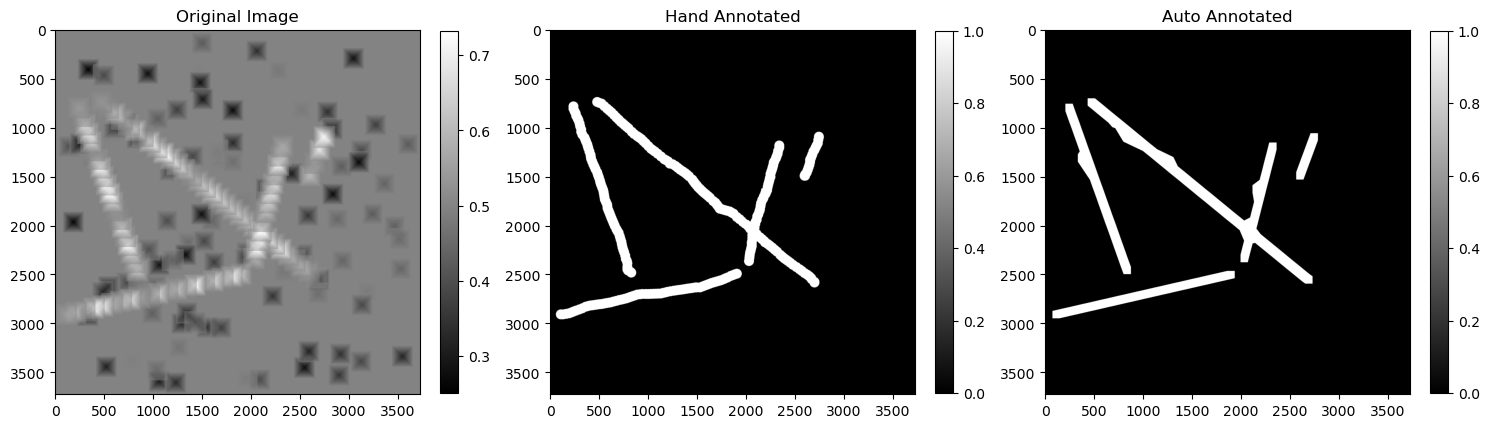

In [8]:
image_dict = {
    "Original Image" : image,
    "Hand Annotated" : hand_anno,
    "Auto Annotated" : auto_anno,
}
plot_image_with_masks(image_dict)

### Calculate IoU - **semantic**

In [9]:
def calculate_overlap(mask1, mask2):
    # Perform element-wise logical AND operation
    overlap_mask = np.logical_and(mask1, mask2)
    return overlap_mask


In [10]:
def calculate_pixel_accuracy(mask1, mask2):
    agreement_mask = mask1 == mask2
    return np.sum(agreement_mask) / agreement_mask.size


In [11]:
def calculate_object_accuracy(mask1, mask2):
    overlap_mask = np.logical_and(mask1, mask2)
    agreement_mask = np.logical_or(mask1, mask2)
    return np.sum(overlap_mask) / np.sum(agreement_mask)


In [12]:
def create_overlay_image(mask1, mask2):
    # Create channels for red, green, and blue
    red_channel = np.where(mask1 & ~mask2, 255, 0)
    green_channel = np.where(~mask1 & mask2, 255, 0)
    blue_channel = np.where(mask1 & mask2, 255, 0)

    # Combine the channels to form an RGB image
    overlay_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    
    return overlay_image

In [17]:
COLOR_MAPPING = {
    "grey" : "image background",
    "gold" : "only in predicted graph",
    "dodgerblue" : "only in ground truth",
    "forestgreen" : "perfect match",
}


In [18]:
def map_values_to_colors(input_image):
    mapping = {
        (0, 0, 0): "grey",   # Map black (0, 0, 0)
        (255, 0, 0): "gold", # Map red (255, 0, 0)
        (0, 255, 0): "dodgerblue", # Map green (0, 255, 0)
        (0, 0, 255): "forestgreen"  # Map blue (0, 0, 255)
    }
    
    output_image = np.zeros_like(input_image, dtype=np.float32)
    legend_patches = []
    
    for rgb_value, mapped_color in mapping.items():
        lab = COLOR_MAPPING[mapped_color]
        patch = mpatches.Patch(color=mapped_color, label=lab)
        legend_patches.append(patch)

        mapped_color = to_rgb(mapped_color)
        mask = np.all(input_image == rgb_value, axis=-1)
        output_image[mask] = mapped_color
    
    return output_image, legend_patches


In [19]:
def visualise_semantic_iou(
    hand_annotated_mask: npt.NDArray, 
    auto_annotated_mask: npt.NDArray, 
    figsize: tuple[int, int] = (10, 10),
) -> None:

    overlap = create_overlay_image(hand_annotated_mask, auto_annotated_mask)
    overlap, patches = map_values_to_colors(overlap)

    # Calculate accuracy metrics
    acc_pix = calculate_pixel_accuracy(hand_annotated_mask, auto_annotated_mask)
    acc_obj = calculate_object_accuracy(hand_annotated_mask, auto_annotated_mask)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(overlap)

    # Add legend
    plt.legend(handles=patches, loc='upper right')
    plt.title(f"IoU Semantic | Pixel Accuracy: {acc_pix:.4f} | Object Accuracy: {acc_obj:.4f}")
    plt.show()

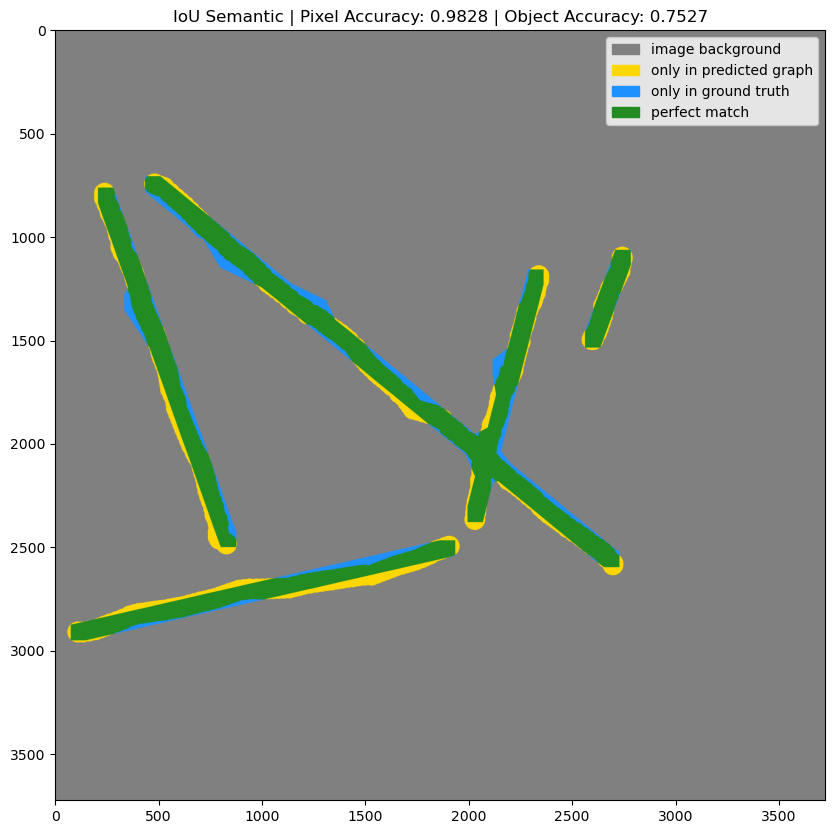

In [20]:
visualise_semantic_iou(hand_anno, auto_anno)

### Now, define instance IoU:

In [78]:
def instance_iou(
    hand_annotated_mask: npt.NDArray, 
    auto_annotated_mask: npt.NDArray
) -> npt.NDArray:

    mask_sum = np.add(
        hand_annotated_mask, 
        auto_annotated_mask
    )
    labeled_map, num_objects = label(mask_sum)
    
    iou_list = []
    for lab_idx in range(1, num_objects + 1):
        
        obj_mask = labeled_map == lab_idx
        union_lab = np.sum(obj_mask)
        
        agreed = hand_annotated_mask[obj_mask] == auto_annotated_mask[obj_mask]
        inter_lab = np.sum(agreed)

        iou = inter_lab / union_lab
        iou_list.append(iou)

    return iou_list
        

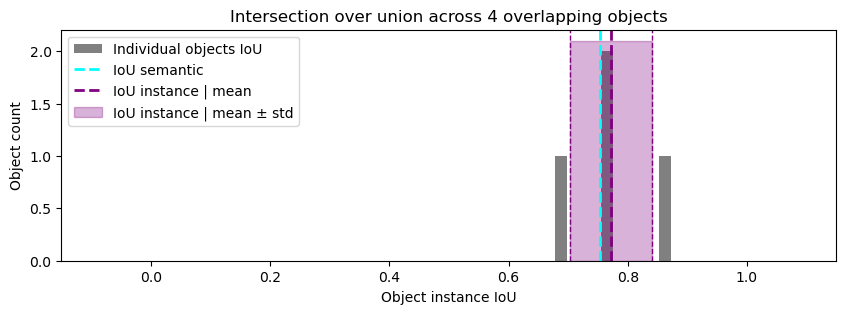

In [79]:
iou_semantic = calculate_object_accuracy(hand_anno, auto_anno)
iou_per_object = instance_iou(hand_anno, auto_anno)
plot_iou_histogram(iou_per_object, iou_semantic)


##### Done!

# TODO: 
* simple IoU between objects
* localisation precision - mean squared displacement between centroids

*Note:* Evaluating the agreement between two resulting images (annotation masks) can involve several metrics to assess different aspects of the agreement. Here are a few metrics you can consider:

Intersection over Union (IoU):

As you mentioned, IoU measures the overlap between two annotation masks. It's defined as the ratio of the intersection of the two masks to their union. You can calculate IoU for each pair of objects that overlap and then compute the mean IoU across all pairs.
Mean Squared Displacement (MSD):

MSD measures the average squared distance between corresponding pixels in two annotation masks. It's a measure of how far the pixels have moved between the two masks. You can calculate the squared Euclidean distance between corresponding pixels and compute the mean across all pairs.
Pixel Accuracy:

Pixel accuracy measures the percentage of correctly labeled pixels in the annotation masks. You compare each pixel in one mask with the corresponding pixel in the other mask and calculate the percentage of pixels that match.
F1 Score:

F1 score combines precision and recall to provide a balanced measure of agreement. You would treat the pixels in one mask as positives and the pixels in the other mask as predicted positives. Then, you calculate precision, recall, and F1 score based on these two sets of pixels.
Dice Coefficient:

The Dice coefficient is another metric commonly used for measuring overlap or agreement between binary images. It's defined as twice the intersection divided by the sum of the sizes of the two masks.
Hausdorff Distance:

Hausdorff distance measures the maximum distance between the pixels in one mask and the closest pixel in the other mask. It captures the maximum displacement between corresponding pixels.
Visual Inspection:

While quantitative metrics are valuable, visual inspection of the resulting images is also crucial. You can overlay the two annotation masks on the original image and visually assess their alignment.
Consistency of Connected Components:

If the annotation masks are expected to form connected components, you can measure the agreement in terms of whether the connected components match between the two masks.
Cluster Matching Metrics:

If your objects can be thought of as clusters or groups of pixels, you can explore metrics designed for clustering, such as adjusted Rand index or normalized mutual information.
Object Detection Metrics:

Depending on the application, you might consider using object detection evaluation metrics such as average precision (AP) if your annotation masks represent object instances.
When comparing two annotation masks, keep in mind the specific characteristics of your data and the goals of your analysis. Depending on the complexity of the images and the nature of the objects you're analyzing, certain metrics may be more appropriate than others. It's also a good idea to use a combination of metrics to get a comprehensive understanding of the agreement between the annotation masks.